In [21]:
import pandas as pd
import numpy as np
from numpy import array
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, ConvLSTM2D, ConvLSTM1D, Dropout,Conv2D, TimeDistributed, Conv1D, MaxPooling1D, Flatten, RepeatVector, MaxPooling2D, MaxPooling3D, BatchNormalization
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping
from datetime import timedelta

In [22]:
df = pd.read_csv('Gold_Price_3.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-05-03,1292.699951,1301.500000,1284.500000,1290.699951,1290.699951,151
1,2016-05-04,1286.900024,1290.000000,1273.000000,1273.300049,1273.300049,109
2,2016-05-05,1282.900024,1286.000000,1270.800049,1271.400024,1271.400024,330
3,2016-05-06,1278.599976,1295.599976,1276.900024,1292.900024,1292.900024,305
4,2016-05-09,1286.500000,1286.500000,1262.300049,1265.599976,1265.599976,341
...,...,...,...,...,...,...,...
1756,2023-04-26,1997.800049,1998.800049,1985.599976,1985.699951,1985.699951,615
1757,2023-04-27,1990.599976,2002.300049,1979.900024,1989.900024,1989.900024,355
1758,2023-04-28,1986.900024,1990.099976,1977.699951,1990.099976,1990.099976,152
1759,2023-05-01,1980.099976,2005.000000,1976.900024,1983.400024,1983.400024,210


In [23]:
df['Date'] = pd.to_datetime(df['Date']) 
df['Date']

0      2016-05-03
1      2016-05-04
2      2016-05-05
3      2016-05-06
4      2016-05-09
          ...    
1756   2023-04-26
1757   2023-04-27
1758   2023-04-28
1759   2023-05-01
1760   2023-05-02
Name: Date, Length: 1761, dtype: datetime64[ns]

In [24]:
data = df[['Close']].values
data

array([[1290.69995117],
       [1273.30004883],
       [1271.40002441],
       ...,
       [1990.09997559],
       [1983.40002441],
       [2014.30004883]])

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [26]:
data_scaled

array([[0.17635586],
       [0.15751868],
       [0.15546171],
       ...,
       [0.93352817],
       [0.92627479],
       [0.95972723]])

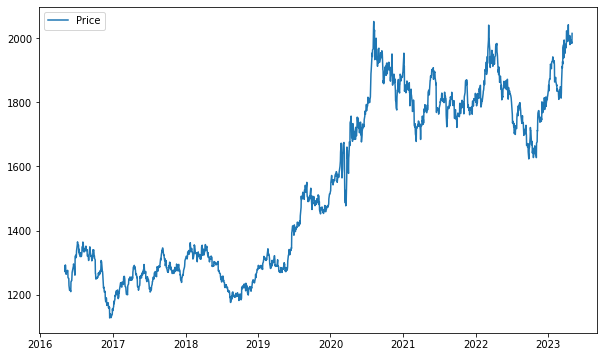

In [27]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'], df[['Close']].values.flatten(), label = "Price")
plt.legend()
plt.show()

In [28]:
def Train_test_split(sequence, n_steps, train_size, test_size):
    data_train = sequence[:train_size]
    data_test = sequence[train_size:train_size+test_size]
    data_valid = sequence[train_size+test_size:]
    
    X_train, X_test, X_valid, y_train, y_test, y_valid = [], [], [], [], [], []
    for i in range(len(data_train) - n_steps):
        X_train.append(data_train[i:i+n_steps]) 
        y_train.append(data_train[i+n_steps])
        
    for i in range(len(data_test) - n_steps):
        X_test.append(data_test[i:i+n_steps]) 
        y_test.append(data_test[i+n_steps])
        
    for i in range(len(data_valid) - n_steps):
        X_valid.append(data_valid[i:i+n_steps]) 
        y_valid.append(data_valid[i+n_steps])
    
    return array(X_train), array(X_test), array(X_valid), array(y_train), array(y_test), array(y_valid)

In [29]:
def LSTM_model(X_train, y_train, X_test, y_test, loss='mse'):
    set_random_seed(42)
    model = Sequential()
    model.add(ConvLSTM1D(filters=64, kernel_size=1, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(Dense(100, activation='relu'))
    model.add((Dense(1)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    # fit model
    callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')
    model.fit(X_train, y_train, epochs=300, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])
    return model

In [30]:
def Eval_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_inverted = scaler.inverse_transform(y_pred.reshape(y_pred.shape[0],-1))
    y_test_inverted = scaler.inverse_transform(y_test.reshape(y_test.shape[0],-1))
    rmse = round(mean_squared_error(y_test_inverted, y_pred_inverted, squared=False),1)
    mape = round(mean_absolute_percentage_error(y_test_inverted, y_pred_inverted)*100,2)
    mae = round(mean_absolute_error(y_test_inverted, y_pred_inverted),1)
    return y_pred_inverted, rmse, mape, mae

In [31]:
RMSE = [0,0,0]
MAPE = [0,0,0]
MAE = [0,0,0]

# Train(60%) - Test(30%) - Valid(10%)

In [32]:
train_size = int(0.6*len(data_scaled))
test_size = int(0.3*len(data_scaled))
valid_size = len(data_scaled) - train_size - test_size
time_step = 100
X_train, X_test, X_valid, y_train, y_test, y_valid = Train_test_split(data_scaled, n_steps=time_step, train_size=train_size, test_size=test_size)

In [33]:
n_seq = 2
X_train = X_train.reshape(X_train.shape[0], n_seq, time_step//n_seq, 1)
X_test = X_test.reshape(X_test.shape[0], n_seq, time_step//n_seq, 1)
X_valid = X_valid.reshape(X_valid.shape[0], n_seq, time_step//n_seq, 1)

In [34]:
X_train.shape

(956, 2, 50, 1)

In [35]:
model = LSTM_model(X_train, y_train, X_test, y_test)

Epoch 1/300
30/30 [==============================] - 12s 99ms/step - loss: 0.0194 - val_loss: 0.0480
Epoch 2/300
30/30 [==============================] - 2s 57ms/step - loss: 0.0035 - val_loss: 0.0655
Epoch 3/300
30/30 [==============================] - 2s 79ms/step - loss: 0.0029 - val_loss: 0.0263
Epoch 4/300
30/30 [==============================] - 2s 65ms/step - loss: 0.0024 - val_loss: 0.0261
Epoch 5/300
30/30 [==============================] - 2s 65ms/step - loss: 0.0017 - val_loss: 0.0303
Epoch 6/300
30/30 [==============================] - 2s 62ms/step - loss: 0.0011 - val_loss: 0.0133
Epoch 7/300
30/30 [==============================] - 2s 58ms/step - loss: 8.4928e-04 - val_loss: 0.0108
Epoch 8/300
30/30 [==============================] - 2s 55ms/step - loss: 7.1816e-04 - val_loss: 0.0103
Epoch 9/300
30/30 [==============================] - 2s 53ms/step - loss: 7.7586e-04 - val_loss: 0.0153
Epoch 10/300
30/30 [==============================] - 2s 55ms/step - loss: 6.5533e-04 -

In [36]:
y_pred_test, rmse, mape, mae = Eval_model(model, X_test, y_test)
y_pred_val, _, _, _ = Eval_model(model, X_valid, y_valid)
RMSE[0] = rmse
MAPE[0] = str(mape)+'%'
MAE[0] = mae
print(f"RMSE score of the model: {rmse}")
print(f"MAPE score of the model: {mape}%")
print(f"MAE score of the model: {mae}")

3/3 [==============================] - 0s 8ms/step
RMSE score of the model: 62.0
MAPE score of the model: 2.93%
MAE score of the model: 52.7


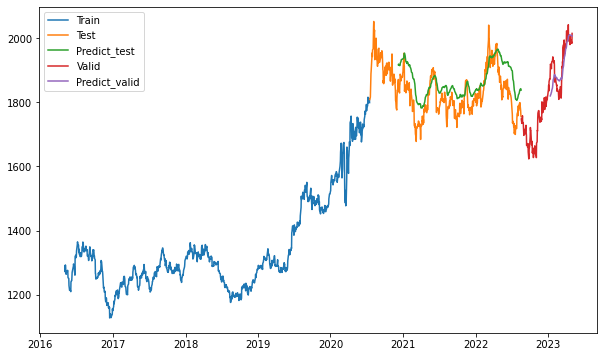

In [37]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'][:train_size], data[:train_size].flatten(), label = "Train")
plt.plot(df['Date'][train_size:train_size+test_size], data[train_size:train_size+test_size].flatten(), label = "Test")
plt.plot(df['Date'][train_size+time_step:train_size+test_size], y_pred_test, label = "Predict_test")
plt.plot(df['Date'][train_size+test_size:], data[train_size+test_size:].flatten(), label = "Valid")
plt.plot(df['Date'][train_size+test_size+time_step:], y_pred_val, label = "Predict_valid")
plt.legend()
plt.show()

# Train(70%) - Test(20%) - Valid(10%)

In [38]:
train_size = int(0.7*len(data_scaled))
test_size = int(0.2*len(data_scaled))
valid_size = len(data_scaled) - train_size - test_size
time_step = 100
X_train, X_test, X_valid, y_train, y_test, y_valid = Train_test_split(data_scaled, n_steps=time_step, train_size=train_size, test_size=test_size)

In [39]:
n_seq = 2
X_train = X_train.reshape(X_train.shape[0], n_seq, time_step//n_seq, 1)
X_test = X_test.reshape(X_test.shape[0], n_seq, time_step//n_seq, 1)
X_valid = X_valid.reshape(X_valid.shape[0], n_seq, time_step//n_seq, 1)

In [40]:
model = LSTM_model(X_train, y_train, X_test, y_test)

Epoch 1/300
36/36 [==============================] - 9s 80ms/step - loss: 0.0322 - val_loss: 0.0246
Epoch 2/300
36/36 [==============================] - 2s 57ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 3/300
36/36 [==============================] - 2s 51ms/step - loss: 0.0047 - val_loss: 0.0056
Epoch 4/300
36/36 [==============================] - 2s 66ms/step - loss: 0.0039 - val_loss: 0.0047
Epoch 5/300
36/36 [==============================] - 2s 57ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 6/300
36/36 [==============================] - 2s 58ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 7/300
36/36 [==============================] - 2s 53ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 8/300
36/36 [==============================] - 2s 51ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 9/300
36/36 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 10/300
36/36 [==============================] - 2s 51ms/step - loss: 9.9501e-04 - val_loss: 0.

In [41]:
y_pred_test, rmse, mape, mae = Eval_model(model, X_test, y_test)
y_pred_val, _, _, _ = Eval_model(model, X_valid, y_valid)
RMSE[1] = rmse
MAPE[1] = str(mape)+'%'
MAE[1] = mae
print(f"RMSE score of the model: {rmse}")
print(f"MAPE score of the model: {mape}%")
print(f"MAE score of the model: {mae}")

3/3 [==============================] - 0s 10ms/step
RMSE score of the model: 35.9
MAPE score of the model: 1.51%
MAE score of the model: 27.7


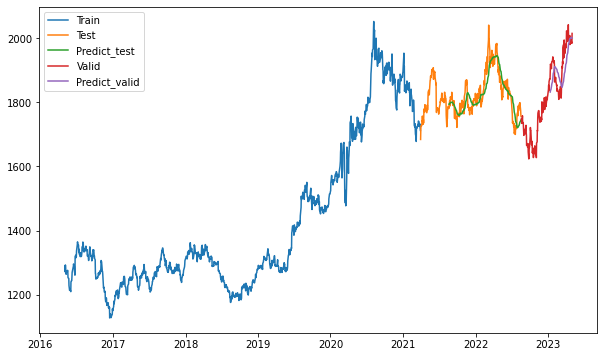

In [42]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'][:train_size], data[:train_size].flatten(), label = "Train")
plt.plot(df['Date'][train_size:train_size+test_size], data[train_size:train_size+test_size].flatten(), label = "Test")
plt.plot(df['Date'][train_size+time_step:train_size+test_size], y_pred_test, label = "Predict_test")
plt.plot(df['Date'][train_size+test_size:], data[train_size+test_size:].flatten(), label = "Valid")
plt.plot(df['Date'][train_size+test_size+time_step:], y_pred_val, label = "Predict_valid")
plt.legend()
plt.show()

# Train(80%) - Test(10%) - Valid(10%)

In [43]:
train_size = int(0.8*len(data_scaled))
test_size = int(0.1*len(data_scaled))
valid_size = len(data_scaled) - train_size - test_size
time_step = 100
X_train, X_test, X_valid, y_train, y_test, y_valid = Train_test_split(data_scaled, n_steps=time_step, train_size=train_size, test_size=test_size)

In [44]:
n_seq = 2
X_train = X_train.reshape(X_train.shape[0], n_seq, time_step//n_seq, 1)
X_test = X_test.reshape(X_test.shape[0], n_seq, time_step//n_seq, 1)
X_valid = X_valid.reshape(X_valid.shape[0], n_seq, time_step//n_seq, 1)

In [45]:
model = LSTM_model(X_train, y_train, X_test, y_test)

Epoch 1/300
41/41 [==============================] - 9s 81ms/step - loss: 0.0340 - val_loss: 0.0077
Epoch 2/300
41/41 [==============================] - 2s 57ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 3/300
41/41 [==============================] - 2s 52ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 4/300
41/41 [==============================] - 2s 47ms/step - loss: 0.0017 - val_loss: 0.0043
Epoch 5/300
41/41 [==============================] - 2s 59ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 6/300
41/41 [==============================] - 3s 67ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 7/300
41/41 [==============================] - 3s 77ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/300
41/41 [==============================] - 3s 78ms/step - loss: 0.0010 - val_loss: 0.0018
Epoch 9/300
41/41 [==============================] - 3s 79ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 10/300
41/41 [==============================] - 3s 80ms/step - loss: 9.2992e-04 - val_loss: 0.

In [46]:
y_pred_test, rmse, mape, mae = Eval_model(model, X_test, y_test)
y_pred_val, _, _, _ = Eval_model(model, X_valid, y_valid)
RMSE[2] = rmse
MAPE[2] = str(mape)+'%'
MAE[2] = mae
print(f"RMSE score of the model: {rmse}")
print(f"MAPE score of the model: {mape}%")
print(f"MAE score of the model: {mae}")

3/3 [==============================] - 0s 8ms/step
RMSE score of the model: 29.6
MAPE score of the model: 1.34%
MAE score of the model: 23.9


In [47]:
y_pred_30days = []
time_30days = pd.Series(pd.date_range(df['Date'][-1:].values[0], periods=30, freq='D'))
temp_input = data_scaled[-time_step:]

In [48]:
for i in tqdm(range(30)):
    pred_next_day = model.predict(temp_input[i:i+time_step].reshape(1,n_seq,time_step//n_seq,1), verbose=0)
    y_pred_30days.append(scaler.inverse_transform(pred_next_day[0])[0][0])
    temp_input = np.append(temp_input, pred_next_day)

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:03<00:00,  9.32it/s]


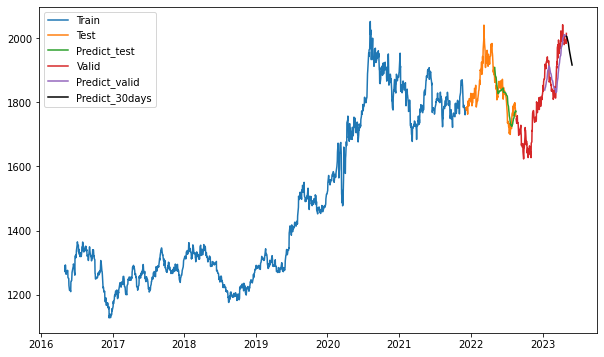

In [49]:
plt.figure(figsize=(10,6))
plt.plot(df['Date'][:train_size], data[:train_size].flatten(), label = "Train")
plt.plot(df['Date'][train_size:train_size+test_size], data[train_size:train_size+test_size].flatten(), label = "Test")
plt.plot(df['Date'][train_size+time_step:train_size+test_size], y_pred_test, label = "Predict_test")
plt.plot(df['Date'][train_size+test_size:], data[train_size+test_size:].flatten(), label = "Valid")
plt.plot(df['Date'][train_size+test_size+time_step:], y_pred_val, label = "Predict_valid")
plt.plot(time_30days, y_pred_30days, label = "Predict_30days", color='black')
plt.legend()
plt.show()

In [50]:
import pandas as pd
pd.DataFrame([RMSE, MAPE, MAE], columns=['6-3-1', '7-2-1', '8-1-1'], index=['RMSE', 'MAPE', 'MAE'])

,6-3-1,7-2-1,8-1-1
RMSE,62.0,35.9,29.6
MAPE,2.93%,1.51%,1.34%
MAE,52.7,27.7,23.9
